In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
# Convert y to one-hot encoded format
y_one_hot = np.eye(3)[y]

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [5]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = []
        self.biases = []

        for i in range(len(layers) - 1):
            w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[i], self.weights[i]) + self.biases[i]
            self.z.append(z)
            a = self.relu(z)
            self.a.append(a)

        # Use softmax for the output layer
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        self.z.append(z)
        a = self.softmax(z)
        self.a.append(a)

        return self.a[-1]

    def backward(self, X, y, learning_rate):
        m = X.shape[0]

        delta = self.a[-1] - y

        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.a[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m

            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db

            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(self.z[i-1])

    def train(self, X, y, epochs, learning_rate, X_val=None, y_val=None):
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X)

            # Backward pass
            self.backward(X, y, learning_rate)

            # Calculate training loss and accuracy
            train_loss = -np.mean(y * np.log(y_pred + 1e-8))
            train_acc = accuracy_score(np.argmax(y, axis=1), np.argmax(y_pred, axis=1))

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)

            # Calculate validation loss and accuracy
            if X_val is not None and y_val is not None:
                y_val_pred = self.predict(X_val)
                val_loss = -np.mean(y_val * np.log(y_val_pred + 1e-8))
                val_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}", end="")
                if X_val is not None:
                    print(f", val_loss={val_loss:.4f}, val_acc={val_acc:.4f}", end="")
                print()

        return history

    def predict(self, X):
        return self.forward(X)

In [7]:
# Create a neural network with 4 input neurons, 10 hidden neurons, and 3 output neurons
nn = NeuralNetwork([4, 100, 3])
nn

In [8]:
# Train the network
history = nn.train(X_train, y_train, epochs=10, learning_rate=0.01, X_val=X_test, y_val=y_test)
history

Epoch 0: train_loss=0.3609, train_acc=0.6417, val_loss=0.3863, val_acc=0.6333


{'train_loss': [0.36088078661971157,
  0.32170032688001376,
  0.2872612684708424,
  0.2575447329416645,
  0.2324608502858749,
  0.2117720369154497,
  0.19507316676790473,
  0.1818313203432099,
  0.17145630943773746,
  0.16337037652137848],
 'train_acc': [0.6416666666666667,
  0.65,
  0.6583333333333333,
  0.6583333333333333,
  0.6833333333333333,
  0.6916666666666667,
  0.7,
  0.75,
  0.7583333333333333,
  0.8],
 'val_loss': [0.3863464137872907,
  0.3395123560553548,
  0.298575302447631,
  0.2636300440208952,
  0.2345188399464386,
  0.21080426205039546,
  0.19183105429373673,
  0.17683258316176012,
  0.16503833168296456,
  0.15575373229437903],
 'val_acc': [0.6333333333333333,
  0.6333333333333333,
  0.6333333333333333,
  0.6333333333333333,
  0.6666666666666666,
  0.7333333333333333,
  0.7333333333333333,
  0.8,
  0.8333333333333334,
  0.8]}

In [9]:
# Make predictions on the test set
y_pred = nn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [10]:
# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8000


In [11]:
# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[10  0  0]
 [ 0  6  3]
 [ 0  3  8]]


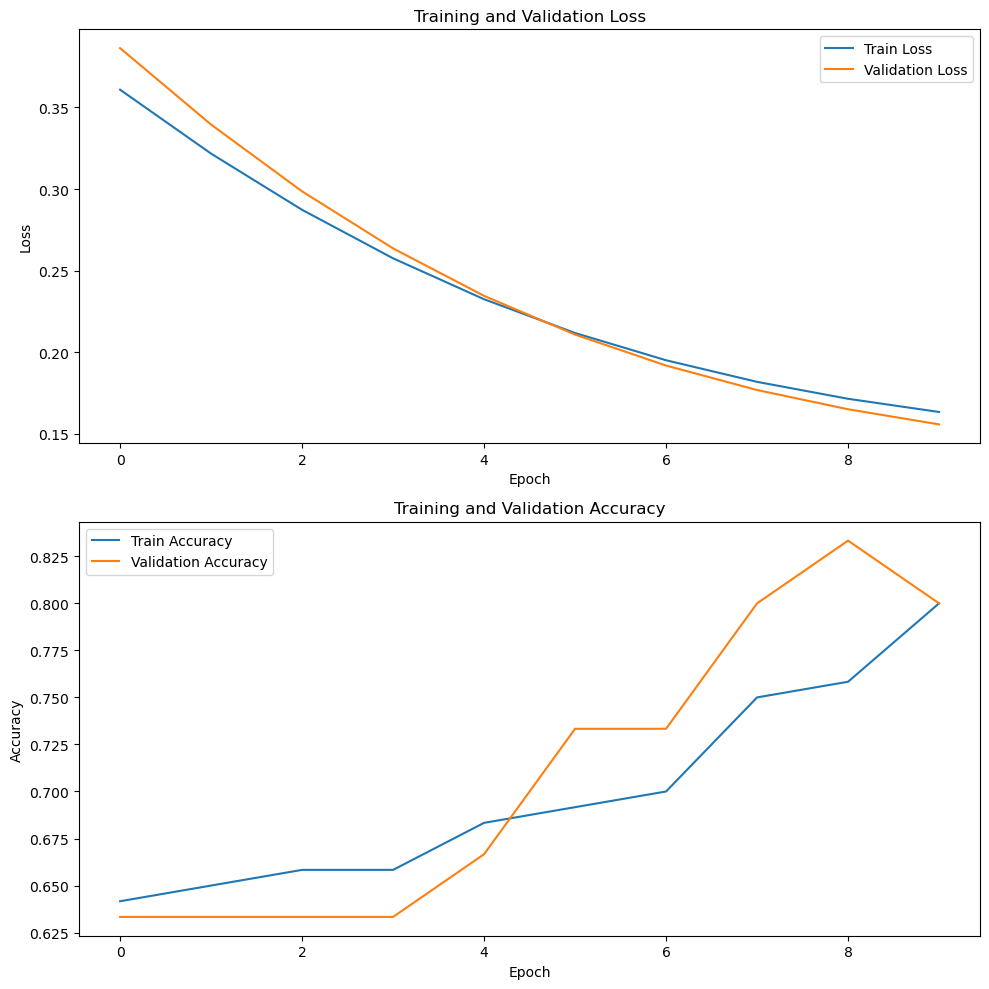

In [12]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.set_title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

plot_history(history)